In [ ]:
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import warnings
import requests
warnings.filterwarnings('ignore')

# 1. Download/Load S&P Stock Price Data

In [82]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36'
}

response = requests.get(url, headers=headers)

response.raise_for_status()

sp500 = pd.read_html(response.text)[0]


sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')


symbol_list = sp500['Symbol'].unique().tolist()


end_date = '2025-09-16'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

df = yf.download(tickers=symbol_list,
                 start=start_date,
                 end=end_date, auto_adjust=False).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%***********************]  503 of 503 completed


#### ETFS Download

In [ ]:
import requests
import pandas as pd
import yfinance as yf
from io import StringIO

import requests
import pandas as pd

url = 'https://api.nasdaq.com/api/screener/etf?download=true'
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()


etf_rows = data['data']['data']['rows']
etf_df = pd.DataFrame(etf_rows)

etf_df['symbol'] = etf_df['symbol'].str.replace('.', '-', regex=False)
etf_list = etf_df['symbol'].dropna().unique().tolist()


end_date = '2025-09-16'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)


def download_batched_etfs(tickers, batch_size=100):
    frames = []
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i+batch_size]
        print(f"Downloading batch {i} to {i+len(batch)}...")
        df_batch = yf.download(
            tickers=batch,
            start=start_date,
            end=end_date,
            auto_adjust=False,
            group_by='ticker'
        )
        frames.append(df_batch)
    return pd.concat(frames, axis=1)

raw_df = download_batched_etfs(etf_list)

df = (raw_df.stack(level=0).sort_index().rename_axis(index=['date', 'ticker']).reset_index())

df.columns = [col.lower() if isinstance(col, str) else col for col in df.columns]
df = df.set_index(['date', 'ticker'])

df


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed

2 Failed downloads:
['SOLT', 'FLEE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-09-16 00:00:00 -> 2025-09-16)')


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  70 of 70 completed


open       high        low      close  adj close  \
date       ticker                                                          
2017-09-18 AADR    56.070000  56.070000  54.790001  55.009998  50.474274   
           AAVM    26.889999  26.889999  26.809999  26.818001  23.571371   
           AAXJ    73.820000  73.919998  73.610001  73.760002  63.303848   
           ABFL    30.580000  30.580000  30.520000  30.520000  26.311293   
           ABLG    26.330000  26.330000  26.329000  26.330000  21.393049   
...                      ...        ...        ...        ...        ...   
2025-09-15 ZTEN    51.779999  51.869999  51.779999  51.826000  51.826000   
           ZTOP    52.749001  52.749001  52.749001  52.749001  52.484001   
           ZTRE    51.410000  51.419998  51.389999  51.404999  51.404999   
           ZTWO    50.930000  50.930000  50.924999  50.924999  50.924999   
           ZVOL    12.370000  12.400000  12.312000  12.312000  12.312000   

                     volume  
date       ticker            
2017-09-18 AADR     44300.0  
           AAVM      2100.0  
           AAXJ    934000.0  
           ABFL      2100.0  
           ABLG      1100.0  
...                     ...  
2025-09-15 ZTEN      3500.0  
           ZTOP       100.0  
           ZTRE      1600.0  
           ZTWO      2100.0  
           ZVOL     13900.0  

[4700912 rows x 6 columns]

# 2. Calculate Features and Technical Indicators for each Stock
* Garman-Klass Volatility
* RSI
* Bollinger Brands
    - The distance between the bands indicates volatility
    - Prices nearing or touching the upper band can suggest an asset is $\textbf{overbought}$
    - Prices nearing or touching the lower band can suggest an asset is $\textbf{oversold}$
* ATR
    - Volatility of stock over certain range
* MACD
* DOllar Volume

Garman-KlassVolatility $ =\frac{(ln(High)-ln(Low))^2}{2}-(2\ln(2)-1)(\ln(\text{Adj Close})-\ln(\text{Open}))^2$

In [170]:
# Garman-Klass Volatility
df['garman_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2
    - (2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open'])) ** 2
)

# RSI
df['rsi'] = df.groupby('ticker')['adj close'].transform(lambda x: ta.rsi(x, length=20))

#df['rsi_state'] = np.select(
#    [df['rsi'] < 30, df['rsi'] > 70],
#    [-1, 1],
#    default=0
#)


# Bollinger Bands
def compute_bb(group, key):
 # log_close = np.log1p(group['adj close'])
 # bb = ta.bbands(close=log_close, length=20)
  bb = ta.bbands(close=group['adj close'], length=20)
  return bb.iloc[:,key]

df['bb_low'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 0)
df['bb_mid'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 1)
df['bb_high'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 2)

df['bb_position'] = ((df['adj close'] - df['bb_low']) / (df['bb_high'] - df['bb_low']))



# ATR
def compute_atr(group):
    atr = ta.atr(group['high'], group['low'], group['close'], length=14)
    #return (atr - atr.mean()) / atr.std()
    return atr

df['atr'] = df.groupby('ticker', group_keys=False).apply(compute_atr)


# MACD
def compute_macd(group):
    macd_line = ta.macd(group, length=20).iloc[:, 0]
    #return (macd_line - macd_line.mean()) / macd_line.std()
    return macd_line

df['macd'] = df.groupby('ticker')['adj close'].transform(compute_macd)


# Dollar Volume
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

df


open       high        low      close  adj close  \
date       ticker                                                          
2017-09-18 AADR    56.070000  56.070000  54.790001  55.009998  50.474274   
           AAVM    26.889999  26.889999  26.809999  26.818001  23.571371   
           AAXJ    73.820000  73.919998  73.610001  73.760002  63.303848   
           ABFL    30.580000  30.580000  30.520000  30.520000  26.311293   
           ABLG    26.330000  26.330000  26.329000  26.330000  21.393049   
...                      ...        ...        ...        ...        ...   
2025-09-15 ZTEN    51.779999  51.869999  51.779999  51.826000  51.826000   
           ZTOP    52.749001  52.749001  52.749001  52.749001  52.484001   
           ZTRE    51.410000  51.419998  51.389999  51.404999  51.404999   
           ZTWO    50.930000  50.930000  50.924999  50.924999  50.924999   
           ZVOL    12.370000  12.400000  12.312000  12.312000  12.312000   

                     volume  garman_klass_vol        rsi     bb_low  \
date       ticker                                                     
2017-09-18 AADR     44300.0     -4.003379e-03        NaN        NaN   
           AAVM      2100.0     -6.697989e-03        NaN        NaN   
           AAXJ    934000.0     -9.114917e-03        NaN        NaN   
           ABFL      2100.0     -8.730067e-03        NaN        NaN   
           ABLG      1100.0     -1.665530e-02        NaN        NaN   
...                     ...               ...        ...        ...   
2025-09-15 ZTEN      3500.0      1.203304e-06  71.876146  49.954863   
           ZTOP       100.0     -9.798645e-06  74.272244  51.550149   
           ZTRE      1600.0      1.666252e-07  73.506201  50.844353   
           ZTWO      2100.0      1.096485e-09  74.235735  50.505089   
           ZVOL     13900.0      1.682924e-05  58.883670  11.684594   

                      bb_mid    bb_high  bb_position       atr      macd  \
date       ticker                                                          
2017-09-18 AADR          NaN        NaN          NaN       NaN       NaN   
           AAVM          NaN        NaN          NaN       NaN       NaN   
           AAXJ          NaN        NaN          NaN       NaN       NaN   
           ABFL          NaN        NaN          NaN       NaN       NaN   
           ABLG          NaN        NaN          NaN       NaN       NaN   
...                      ...        ...          ...       ...       ...   
2025-09-15 ZTEN    50.961848  51.968833     0.929079  0.174935  0.378580   
           ZTOP    52.033774  52.517398     0.965472  0.096967  0.196059   
           ZTRE    51.163195  51.482037     0.879191  0.065537  0.151856   
           ZTWO    50.746517  50.987946     0.869637  0.043766  0.112961   
           ZVOL    12.080518  12.476442     0.792332  0.180555  0.136570   

                   dollar_volume  
date       ticker                 
2017-09-18 AADR         2.236010  
           AAVM         0.049500  
           AAXJ        59.125794  
           ABFL         0.055254  
           ABLG         0.023532  
...                          ...  
2025-09-15 ZTEN         0.181391  
           ZTOP         0.005248  
           ZTRE         0.082248  
           ZTWO         0.106942  
           ZVOL         0.171137  

[4700912 rows x 15 columns]

# 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month

In [84]:
#df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

In [85]:
#last_cols = [col for col in df.columns.unique(0) if col not in ['dollar_volume','volume','open',
#                                                                'high', 'low', 'close']]
#last_cols

In [194]:

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
data



dollar_volume  adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2017-10-31 AADR         1.905125  52.758968     -2.441617e-03  71.215809   
           AAVM         0.230372  24.617456     -5.771420e-03  80.881711   
           AAXJ        74.639080  64.634125     -8.750403e-03  61.408691   
           ABFL         0.168048  27.621687     -8.084837e-03  67.578606   
           ABLG         0.025414  21.657112     -1.620237e-02  60.886583   
...                          ...        ...               ...        ...   
2025-09-30 ZTEN         0.120687  51.826000      1.203304e-06  71.876146   
           ZTOP         0.018774  52.484001     -9.798645e-06  74.272244   
           ZTRE         0.058460  51.404999      1.666252e-07  73.506201   
           ZTWO         0.018322  50.924999      1.096485e-09  74.235735   
           ZVOL         0.229088  12.312000      1.682924e-05  58.883670   

                      bb_low     bb_mid    bb_high  bb_position       atr  \
date       ticker                                                           
2017-10-31 AADR    51.588079  52.468570  53.349061     0.664907  0.670110   
           AAVM    23.971812  24.312837  24.653863     0.946622  0.120601   
           AAXJ    62.964633  63.973712  64.982790     0.827236  0.636386   
           ABFL    27.130754  27.439093  27.747432     0.796092  0.272539   
           ABLG    21.282422  21.485835  21.689249     0.921006  0.149701   
...                      ...        ...        ...          ...       ...   
2025-09-30 ZTEN    49.954863  50.961848  51.968833     0.929079  0.174935   
           ZTOP    51.550149  52.033774  52.517398     0.965472  0.096967   
           ZTRE    50.844353  51.163195  51.482037     0.879191  0.065537   
           ZTWO    50.505089  50.746517  50.987946     0.869637  0.043766   
           ZVOL    11.684594  12.080518  12.476442     0.792332  0.180555   

                       macd  
date       ticker            
2017-10-31 AADR    0.564047  
           AAVM    0.228885  
           AAXJ    0.531713  
           ABFL    0.269671  
           ABLG    0.051782  
...                     ...  
2025-09-30 ZTEN    0.378580  
           ZTOP    0.196059  
           ZTRE    0.151856  
           ZTWO    0.112961  
           ZVOL    0.136570  

[224217 rows x 10 columns]

#### Calculate 5 year rolling average of dollar volume for each stock before filtering

In [195]:
data['dollar_volume'] = data['dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_vol_rank'] < 150].drop(columns=['dollar_vol_rank','dollar_vol_rank'],axis=1)
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2018-09-30 AAXJ        71.833397   61.939880         -0.006511  49.814884   
           ACWI       136.203220   65.242416         -0.006327  56.667726   
           AGG        298.256049   86.729721         -0.015099  45.401990   
           AMLP        85.933492   29.191114         -0.136418  45.900575   
           BIL         57.069589   77.232338         -0.011201  87.555864   
...                          ...         ...               ...        ...   
2025-09-30 XLV       1236.809037  136.929993          0.000057  52.353464   
           XLY        893.416655  240.699997          0.000071  66.521289   
           XME        172.739026   89.089996          0.000288  74.464524   
           XOP        575.077304  129.339996          0.000100  51.533560   
           XRT        356.849468   87.559998          0.000076  61.048921   

                       bb_low      bb_mid     bb_high  bb_position       atr  \
date       ticker                                                              
2018-09-30 AAXJ     59.419903   61.290301   63.160698     0.673647  0.848572   
           ACWI     63.390987   64.698128   66.005269     0.708198  0.500670   
           AGG      86.399249   86.869360   87.339471     0.351483  0.202664   
           AMLP     28.863453   29.573767   30.284081     0.230646  0.663268   
           BIL      77.109699   77.179690   77.249681     0.876103  0.018277   
...                       ...         ...         ...          ...       ...   
2025-09-30 XLV     135.650000  137.388498  139.126996     0.368132  1.657083   
           XLY     226.062432  233.261001  240.459570     1.016700  3.024082   
           XME      75.847176   81.983000   88.118824     1.079140  1.745171   
           XOP     122.781468  129.390499  135.999531     0.496179  2.707849   
           XRT      82.660582   85.582499   88.504416     0.838391  1.443510   

                       macd  
date       ticker            
2018-09-30 AAXJ    0.010636  
           ACWI    0.310719  
           AGG    -0.112606  
           AMLP   -0.191102  
           BIL     0.039630  
...                     ...  
2025-09-30 XLV     0.975495  
           XLY     3.346084  
           XME     2.577772  
           XOP     0.962573  
           XRT     1.405298  

[12665 rows x 10 columns]

In [196]:
"""def standardize(df):
  return (df - df.mean())/df.std()

data['bb_low'] = standardize(data['bb_low'])
data['bb_mid'] = standardize(data['bb_mid'])
data['bb_high'] = standardize(data['bb_high'])
data"""

"def standardize(df):\n  return (df - df.mean())/df.std()\n\ndata['bb_low'] = standardize(data['bb_low'])\ndata['bb_mid'] = standardize(data['bb_mid'])\ndata['bb_high'] = standardize(data['bb_high'])\ndata"

# 4. Calculate Monthly Returns for different time horizens as features
* to capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags

In [197]:
def calculate_returns(df):
    outlier_cutoff = 0.005

    lags = [1,2,3,6,9,12]

    for lag in lags:
      df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))

    return df

data = data.groupby('ticker', group_keys=False).apply(calculate_returns).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2019-09-30 AAXJ        77.346276   59.393578         -0.004901  47.413100   
           ACWI       184.087324   66.260620         -0.004220  53.125924   
           AGG        366.377397   95.922897         -0.010287  56.061835   
           AMLP        91.397700   27.049547         -0.104422  45.325667   
           BIL        109.705593   78.926628         -0.008541  86.412306   
...                          ...         ...               ...        ...   
2025-09-30 XLV       1236.809037  136.929993          0.000057  52.353464   
           XLY        893.416655  240.699997          0.000071  66.521289   
           XME        172.739026   89.089996          0.000288  74.464524   
           XOP        575.077304  129.339996          0.000100  51.533560   
           XRT        356.849468   87.559998          0.000076  61.048921   

                       bb_low      bb_mid     bb_high  bb_position       atr  \
date       ticker                                                              
2019-09-30 AAXJ     58.487436   60.221526   61.955616     0.261273  0.748527   
           ACWI     65.098686   66.352710   67.606735     0.463282  0.662924   
           AGG      94.670154   95.696577   96.723001     0.610247  0.383185   
           AMLP     26.449512   27.376565   28.303618     0.323625  0.699175   
           BIL      78.785716   78.862860   78.940003     0.913310  0.019602   
...                       ...         ...         ...          ...       ...   
2025-09-30 XLV     135.650000  137.388498  139.126996     0.368132  1.657083   
           XLY     226.062432  233.261001  240.459570     1.016700  3.024082   
           XME      75.847176   81.983000   88.118824     1.079140  1.745171   
           XOP     122.781468  129.390499  135.999531     0.496179  2.707849   
           XRT      82.660582   85.582499   88.504416     0.838391  1.443510   

                       macd  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                         
2019-09-30 AAXJ    0.111485   0.015931  -0.011412  -0.016856  -0.009556   
           ACWI    0.288247   0.022459  -0.000068   0.000181   0.005760   
           AGG     0.067190  -0.006121   0.010711   0.007738   0.008532   
           AMLP    0.020864   0.005501  -0.025621  -0.017820  -0.008649   
           BIL     0.044048   0.001618   0.001657   0.001706   0.001830   
...                     ...        ...        ...        ...        ...   
2025-09-30 XLV     0.975495  -0.003638   0.024615   0.005264  -0.009858   
           XLY     3.346084   0.038664   0.042605   0.034631   0.033919   
           XME     2.577772   0.082109   0.102309   0.098441   0.080735   
           XOP     0.962573  -0.027592   0.004632   0.009293  -0.002090   
           XRT     1.405298   0.040028   0.056401   0.043500   0.040738   

                   return_9m  return_12m  
date       ticker                         
2019-09-30 AAXJ     0.005480   -0.003492  
           ACWI     0.017013    0.001291  
           AGG      0.008918    0.008431  
           AMLP     0.011905   -0.006329  
           BIL      0.001814    0.001810  
...                      ...         ...  
2025-09-30 XLV      0.000440   -0.008668  
           XLY      0.008392    0.015972  
           XME      0.051688    0.028642  
           XOP     -0.001304    0.000093  
           XRT      0.011255    0.011049  

[10463 rows x 16 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas


#### Filter out stocks with less than 10 months of data

In [198]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 AAXJ    0.0142  0.0029  0.0676  0.0182  0.0338   0.015931
           ACWI    0.0142  0.0029  0.0676  0.0182  0.0338   0.022459
           AGG     0.0142  0.0029  0.0676  0.0182  0.0338  -0.006121
           AMLP    0.0142  0.0029  0.0676  0.0182  0.0338   0.005501
           BIL     0.0142  0.0029  0.0676  0.0182  0.0338   0.001618
...                   ...     ...     ...     ...     ...        ...
2025-06-30 XLV     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.021060
           XLY     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.018672
           XME     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.120008
           XOP     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.058194
           XRT     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.017591

[10042 rows x 6 columns]

In [199]:
observations = factor_data.groupby('ticker').size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 AAXJ    0.0142  0.0029  0.0676  0.0182  0.0338   0.015931
           ACWI    0.0142  0.0029  0.0676  0.0182  0.0338   0.022459
           AGG     0.0142  0.0029  0.0676  0.0182  0.0338  -0.006121
           AMLP    0.0142  0.0029  0.0676  0.0182  0.0338   0.005501
           BIL     0.0142  0.0029  0.0676  0.0182  0.0338   0.001618
...                   ...     ...     ...     ...     ...        ...
2025-06-30 XLV     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.021060
           XLY     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.018672
           XME     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.120008
           XOP     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.058194
           XRT     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.017591

[9994 rows x 6 columns]

In [200]:
betas = (factor_data.groupby('ticker', group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                      window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params.drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-09-30 AAXJ         NaN       NaN       NaN       NaN       NaN
           ACWI         NaN       NaN       NaN       NaN       NaN
           AGG          NaN       NaN       NaN       NaN       NaN
           AMLP         NaN       NaN       NaN       NaN       NaN
           BIL          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-06-30 XLV     0.726465 -0.506804  0.986340 -0.128774 -0.858013
           XLY     0.880935  0.558328 -0.572903 -0.229030 -0.177859
           XME     0.838415  0.659658  0.464514 -0.178173  0.239945
           XOP     0.892181  0.304675  0.563759  1.337603  0.377679
           XRT     1.187579  0.896293 -0.220837  0.376183 -0.145360

[9994 rows x 5 columns]

In [201]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop(['adj close','dollar_volume'], axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10215 entries, (Timestamp('2019-09-30 00:00:00'), 'AAXJ') to (Timestamp('2025-09-30 00:00:00'), 'XRT')
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10215 non-null  float64
 1   rsi               10215 non-null  float64
 2   bb_low            10215 non-null  float64
 3   bb_mid            10215 non-null  float64
 4   bb_high           10215 non-null  float64
 5   bb_position       10215 non-null  float64
 6   atr               10215 non-null  float64
 7   macd              10215 non-null  float64
 8   return_1m         10215 non-null  float64
 9   return_2m         10215 non-null  float64
 10  return_3m         10215 non-null  float64
 11  return_6m         10215 non-null  float64
 12  return_9m         10215 non-null  float64
 13  return_12m        10215 non-null  float64
 14  Mkt-RF            10215 non-null  float64
 15  SMB       

In [202]:
data.drop(columns=['bb_low', 'bb_mid', 'bb_high'], inplace=True)

In [ ]:


TARGET_RSI_RAW = [30, 45, 55, 70]  # raw RSI thresholds

def get_clusters(month_df: pd.DataFrame) -> pd.DataFrame:
    # 1) choose numeric feature set (exclude existing 'cluster' if present)
    numeric_cols = month_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'cluster' in numeric_cols:
        numeric_cols.remove('cluster')

    X = month_df[numeric_cols].copy()

    # 2) fit cross-sectional scaler for THIS month and transform
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        index=X.index,
        columns=numeric_cols
    )

    # 3) convert raw RSI targets -> THIS month's z-scores
    #    using the scaler stats for the RSI column
    rsi_col = 'rsi'
    if rsi_col not in numeric_cols:
        raise ValueError(f"'{rsi_col}' must be in columns to seed centroids.")

    rsi_idx = numeric_cols.index(rsi_col)
    rsi_mean = scaler.mean_[rsi_idx]
    rsi_std  = scaler.scale_[rsi_idx]

    if np.isclose(rsi_std, 0.0):
        # degenerate case: no dispersion in RSI this month
        rsi_targets_z = [0.0] * len(TARGET_RSI_RAW)
    else:
        rsi_targets_z = [(t - rsi_mean) / rsi_std for t in TARGET_RSI_RAW]

    # 4) build centroid matrix (n_clusters x n_features), default 0 (mean in z-space)
    n_features = len(numeric_cols)
    initial_centroids = np.zeros((len(rsi_targets_z), n_features))
    initial_centroids[:, rsi_idx] = rsi_targets_z

    # (optional) nudge more features than RSI, e.g. high/low 1m return:
    # initial_centroids[0, numeric_cols.index('return_1m')] = -1.0   # oversold + weak momentum
    # initial_centroids[-1, numeric_cols.index('return_1m')] =  1.0  # overbought + strong momentum

    # 5) run KMeans on scaled data with explicit init
    km = KMeans(
        n_clusters=len(TARGET_RSI_RAW),
        init=initial_centroids,
        n_init=1,            # must be 1 when passing explicit centroids
        random_state=0
    )
    labels = km.fit_predict(X_scaled)

    # 6) return original month_df plus cluster labels (don’t overwrite your scaled features unless you want to)
    out = month_df.copy()
    out['cluster'] = labels
    return out

# usage: group by month (date) and apply
data = (
    data.dropna()
        .groupby('date', group_keys=False)
        .apply(get_clusters)
)


#### Attempt:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class FinancialKMeans:
    def __init__(self, n_clusters=4, random_state=0, scale_method='standard',
                 use_financial_centroids=True):
        """
        K-means clustering optimized for financial data

        Parameters:
        - n_clusters: number of clusters (typically 4 for financial regimes)
        - scale_method: 'standard', 'robust', or None
        - use_financial_centroids: whether to use finance-informed initialization
        """
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.scale_method = scale_method
        self.use_financial_centroids = use_financial_centroids
        self.scaler = None
        self.kmeans = None
        self.feature_names = None
        self.centroids_scaled = None

        # Initialize scaler
        if scale_method == 'standard':
            self.scaler = StandardScaler()
        elif scale_method == 'robust':
            self.scaler = RobustScaler()  # Less sensitive to outliers

    def create_financial_centroids(self, df):
        """
        Create financially meaningful centroids based on market regimes
        """
        n_features = len(df.columns)
        centroids = np.zeros((self.n_clusters, n_features))

        # Find RSI column index
        rsi_idx = None
        for i, col in enumerate(df.columns):
            if 'rsi' in col.lower():
                rsi_idx = i
                break

        if rsi_idx is None:
            print("Warning: RSI column not found, using k-means++ initialization")
            return 'k-means++'

        # Define market regimes based on RSI and other indicators
        regimes = {
            0: {'name': 'Oversold/Bottom', 'rsi': 30, 'momentum_factor': -1},
            1: {'name': 'Neutral/Accumulation', 'rsi': 45, 'momentum_factor': 0},
            2: {'name': 'Bullish/Distribution', 'rsi': 55, 'momentum_factor': 0.5},
            3: {'name': 'Overbought/Top', 'rsi': 70, 'momentum_factor': 1}
        }

        # Calculate target values for each regime
        rsi_mean = df.iloc[:, rsi_idx].mean()
        rsi_std = df.iloc[:, rsi_idx].std()

        for cluster_idx, regime in regimes.items():
            # Set RSI target (standardized)
            centroids[cluster_idx, rsi_idx] = (regime['rsi'] - rsi_mean) / rsi_std

            # Set other financial indicators based on regime characteristics
            for feat_idx, col in enumerate(df.columns):
                if feat_idx == rsi_idx:
                    continue

                col_lower = col.lower()
                feat_mean = df.iloc[:, feat_idx].mean()
                feat_std = df.iloc[:, feat_idx].std()

                # Volume indicators (higher in extreme conditions)
                if 'volume' in col_lower or 'vol' in col_lower:
                    if cluster_idx in [0, 3]:  # Oversold/Overbought
                        centroids[cluster_idx, feat_idx] = (feat_mean + feat_std) / feat_std
                    else:
                        centroids[cluster_idx, feat_idx] = 0

                # Momentum indicators
                elif any(x in col_lower for x in ['macd', 'momentum', 'roc', 'williams']):
                    momentum = regime['momentum_factor']
                    centroids[cluster_idx, feat_idx] = momentum * feat_std / feat_std

                # Volatility indicators (higher in extreme regimes)
                elif any(x in col_lower for x in ['atr', 'volatility', 'bb']):
                    if cluster_idx in [0, 3]:
                        centroids[cluster_idx, feat_idx] = (feat_mean + 0.5 * feat_std) / feat_std
                    else:
                        centroids[cluster_idx, feat_idx] = 0

                # Moving averages and trend indicators
                elif any(x in col_lower for x in ['ma', 'ema', 'sma']):
                    # Bullish regimes above MA, bearish below
                    if cluster_idx >= 2:  # Bullish regimes
                        centroids[cluster_idx, feat_idx] = 0.5
                    else:  # Bearish regimes
                        centroids[cluster_idx, feat_idx] = -0.5

                # Default: slight bias based on regime
                else:
                    centroids[cluster_idx, feat_idx] = regime['momentum_factor'] * 0.3

        return centroids

    def evaluate_clustering_quality(self, df_scaled, labels):
        """
        Evaluate clustering quality using multiple metrics
        """
        metrics = {}

        if len(set(labels)) > 1:
            metrics['silhouette'] = silhouette_score(df_scaled, labels)
            metrics['calinski_harabasz'] = calinski_harabasz_score(df_scaled, labels)
            metrics['inertia'] = self.kmeans.inertia_

            # Financial-specific metrics
            cluster_counts = pd.Series(labels).value_counts()
            metrics['balance'] = cluster_counts.min() / cluster_counts.max()  # Balance of clusters

        return metrics

    def find_optimal_clusters_financial(self, df, max_clusters=8):
        """
        Find optimal clusters considering financial market regimes
        """
        if len(df) < max_clusters:
            max_clusters = len(df) - 1

        results = {}
        cluster_range = range(2, min(max_clusters + 1, len(df)))

        # Scale data once
        if self.scaler:
            df_scaled = self.scaler.fit_transform(df)
        else:
            df_scaled = df.values

        for k in cluster_range:
            # Use financial centroids if available
            if self.use_financial_centroids and k == 4:
                init_centroids = self.create_financial_centroids(df)
                if isinstance(init_centroids, np.ndarray):
                    init_centroids = self.scaler.transform(init_centroids) if self.scaler else init_centroids
            else:
                init_centroids = 'k-means++'

            kmeans_temp = KMeans(
                n_clusters=k,
                random_state=self.random_state,
                init=init_centroids,
                n_init=10 if isinstance(init_centroids, str) else 1,
                max_iter=300
            )

            labels = kmeans_temp.fit_predict(df_scaled)

            if len(set(labels)) > 1:
                sil_score = silhouette_score(df_scaled, labels)
                ch_score = calinski_harabasz_score(df_scaled, labels)

                results[k] = {
                    'silhouette': sil_score,
                    'calinski_harabasz': ch_score,
                    'inertia': kmeans_temp.inertia_,
                    'balance': pd.Series(labels).value_counts().min() / pd.Series(labels).value_counts().max()
                }

        # Recommend based on combined criteria
        if results:
            # Weight financial considerations (4 clusters often optimal for market regimes)
            best_k = max(results.keys(), key=lambda k: (
                results[k]['silhouette'] * 0.4 +
                results[k]['balance'] * 0.3 +
                (0.2 if k == 4 else 0) +  # Bonus for 4 clusters (market regimes)
                (results[k]['calinski_harabasz'] / max(r['calinski_harabasz'] for r in results.values())) * 0.3
            ))

            print(f"Recommended clusters: {best_k}")
            print(f"Silhouette score: {results[best_k]['silhouette']:.3f}")
            print(f"Cluster balance: {results[best_k]['balance']:.3f}")

            return best_k, results

        return 4, {}  # Default to 4 for financial data

    def get_clusters(self, df, optimize_k=False):
        """
        Main clustering function for financial data
        """
        if df.empty:
            print("Warning: Empty DataFrame provided")
            return df

        self.feature_names = df.columns.tolist()

        # Handle insufficient samples
        if len(df) < self.n_clusters:
            print(f"Warning: Not enough samples ({len(df)}) for {self.n_clusters} clusters")
            n_clusters_adj = max(1, min(len(df), 2))
            use_financial_init = False
        else:
            n_clusters_adj = self.n_clusters
            use_financial_init = self.use_financial_centroids

        # Optimize clusters if requested
        if optimize_k and len(df) > 4:
            optimal_k, results = self.find_optimal_clusters_financial(df)
            n_clusters_adj = optimal_k

        try:
            # Scale the data
            if self.scaler:
                df_scaled = self.scaler.fit_transform(df)
            else:
                df_scaled = df.values

            # Create financial centroids if using them
            init_method = 'k-means++'
            if use_financial_init and n_clusters_adj == 4:
                centroids = self.create_financial_centroids(df)
                if isinstance(centroids, np.ndarray):
                    if self.scaler:
                        # Scale the centroids using the same scaler
                        self.centroids_scaled = self.scaler.transform(centroids)
                    else:
                        self.centroids_scaled = centroids
                    init_method = self.centroids_scaled
                    print("Using financial regime-based centroids")

            # Fit K-means
            self.kmeans = KMeans(
                n_clusters=n_clusters_adj,
                random_state=self.random_state,
                init=init_method,
                n_init=1 if isinstance(init_method, np.ndarray) else 10,
                max_iter=300
            )

            labels = self.kmeans.fit_predict(df_scaled)

            # Evaluate clustering quality
            metrics = self.evaluate_clustering_quality(df_scaled, labels)
            if metrics:
                print(f"Clustering quality metrics:")
                for metric, value in metrics.items():
                    print(f"  {metric}: {value:.3f}")

            # Create result dataframe
            df_result = df.copy()
            df_result['cluster'] = labels

            return df_result

        except Exception as e:
            print(f"Clustering failed: {str(e)}")
            df_result = df.copy()
            df_result['cluster'] = 0
            return df_result

    def analyze_clusters(self, df_clustered):
        """
        Analyze the financial characteristics of each cluster
        """
        if 'cluster' not in df_clustered.columns:
            return None

        cluster_summary = {}

        for cluster_id in sorted(df_clustered['cluster'].unique()):
            cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]

            summary = {
                'count': len(cluster_data),
                'percentage': len(cluster_data) / len(df_clustered) * 100
            }

            # Financial indicator summaries
            for col in df_clustered.columns:
                if col == 'cluster':
                    continue

                col_lower = col.lower()
                values = cluster_data[col]

                summary[col] = {
                    'mean': values.mean(),
                    'std': values.std(),
                    'min': values.min(),
                    'max': values.max()
                }

                # Add financial interpretations
                if 'rsi' in col_lower:
                    mean_rsi = values.mean()
                    if mean_rsi < 35:
                        summary[f'{col}_regime'] = 'Oversold'
                    elif mean_rsi > 65:
                        summary[f'{col}_regime'] = 'Overbought'
                    else:
                        summary[f'{col}_regime'] = 'Neutral'

            cluster_summary[cluster_id] = summary

        return cluster_summary



def cluster_financial_data(data, n_clusters=4, scale_method='robust',
                         use_financial_centroids=True, optimize_k=False):
    """
    Main function to cluster financial data with market regime awareness
    """
    # Remove existing cluster column
    if 'cluster' in data.columns:
        data = data.drop('cluster', axis=1)

    print(f"Original data shape: {data.shape}")
    print(f"Missing values: {data.isnull().sum().sum()}")

    # Handle missing values
    data_clean = data.dropna()
    print(f"Data shape after cleaning: {data_clean.shape}")

    # Initialize financial K-means
    fin_kmeans = FinancialKMeans(
        n_clusters=n_clusters,
        scale_method=scale_method,
        use_financial_centroids=use_financial_centroids,
        random_state=0
    )

    # Apply clustering by date
    def apply_financial_clustering(group):
        return fin_kmeans.get_clusters(group, optimize_k=optimize_k)

    try:
        if 'date' in data_clean.columns:
            clustered_data = data_clean.groupby('date', group_keys=False).apply(apply_financial_clustering)
        else:
            clustered_data = fin_kmeans.get_clusters(data_clean, optimize_k=optimize_k)

        print(f"\nClustering completed!")
        print(f"Final data shape: {clustered_data.shape}")
        print(f"Cluster distribution:\n{clustered_data['cluster'].value_counts().sort_index()}")

        # Analyze clusters
        cluster_analysis = fin_kmeans.analyze_clusters(clustered_data)
        if cluster_analysis:
            print("\nCluster Analysis:")
            for cluster_id, analysis in cluster_analysis.items():
                print(f"\nCluster {cluster_id}: {analysis['count']} samples ({analysis['percentage']:.1f}%)")

        return clustered_data, fin_kmeans

    except Exception as e:
        print(f"Error in clustering: {str(e)}")
        return data_clean, None

 #Example usage:
clustered_data, kmeans_model = cluster_financial_data(
     data,
     n_clusters=4,
     scale_method='robust',  # Better for financial data with outliers
     use_financial_centroids=True,
     optimize_k=False
 )

# # Visualize results
#if kmeans_model:
#     kmeans_model.plot_clusters(clustered_data)

Original data shape: (13780, 18)
Missing values: 0
Data shape after cleaning: (13780, 18)
Using financial regime-based centroids
Clustering quality metrics:
  silhouette: 0.163
  calinski_harabasz: 2796.697
  inertia: 164660.099
  balance: 0.024

Clustering completed!
Final data shape: (13780, 19)
Cluster distribution:
cluster
0     153
1    5956
2    6440
3    1231
Name: count, dtype: int64

Cluster Analysis:

Cluster 0: 153 samples (1.1%)

Cluster 1: 5956 samples (43.2%)

Cluster 2: 6440 samples (46.7%)

Cluster 3: 1231 samples (8.9%)


In [ ]:
data = clustered_data

#### Plot

In [192]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

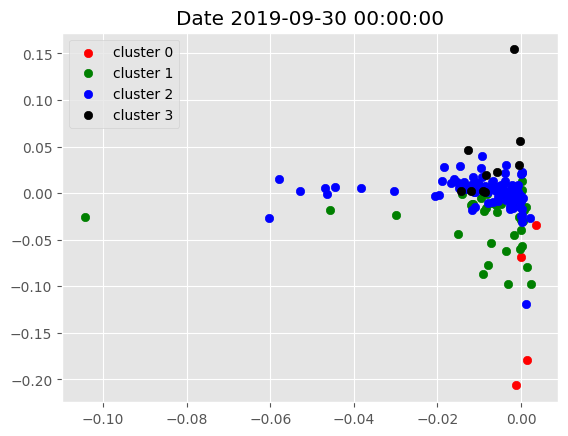

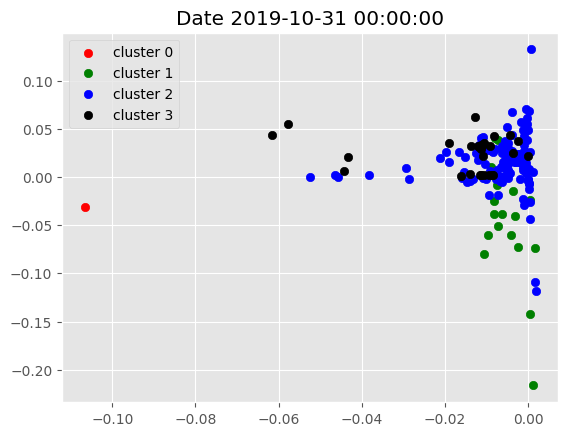

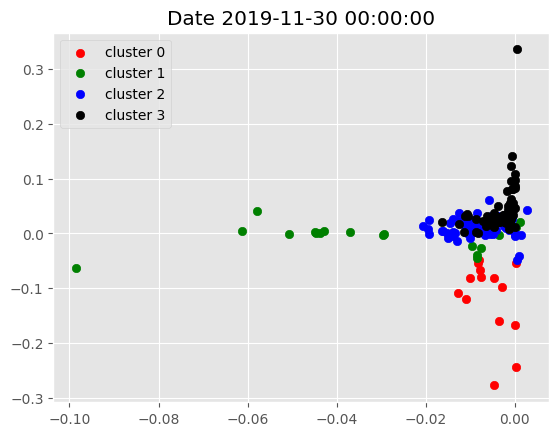

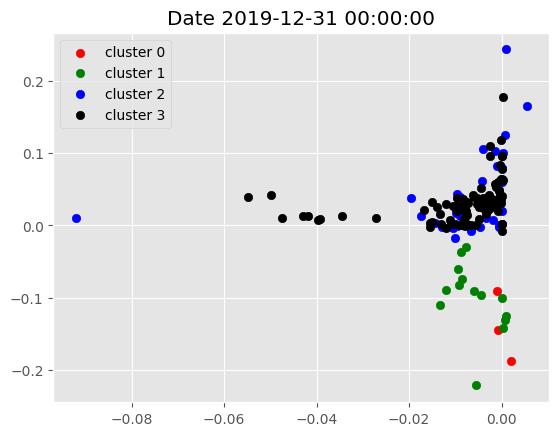

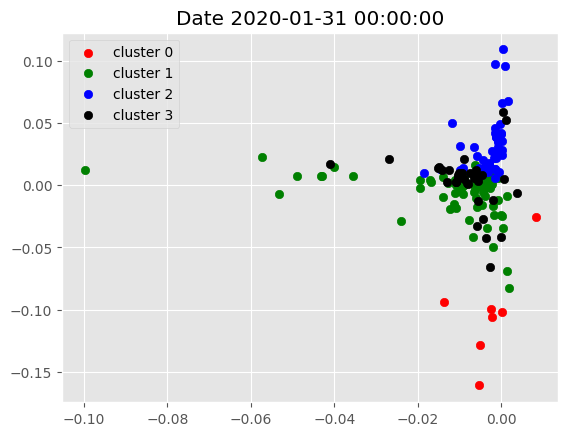

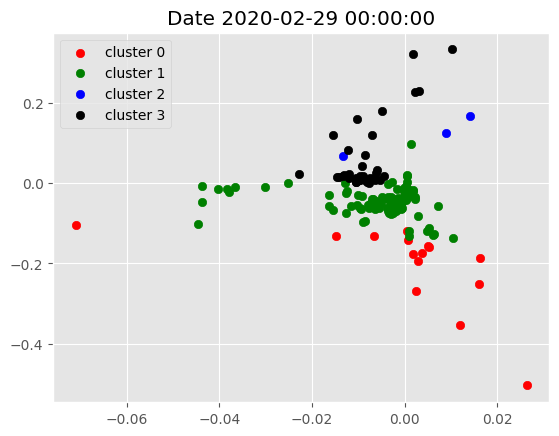

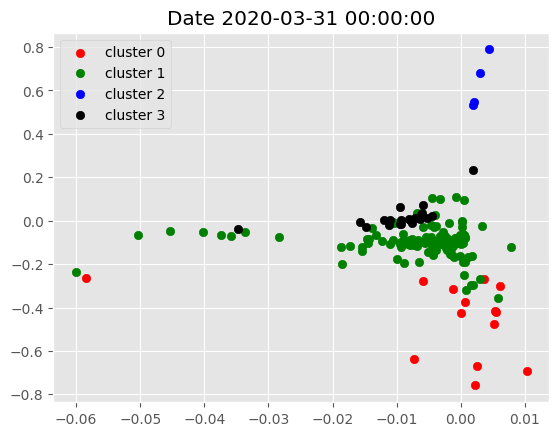

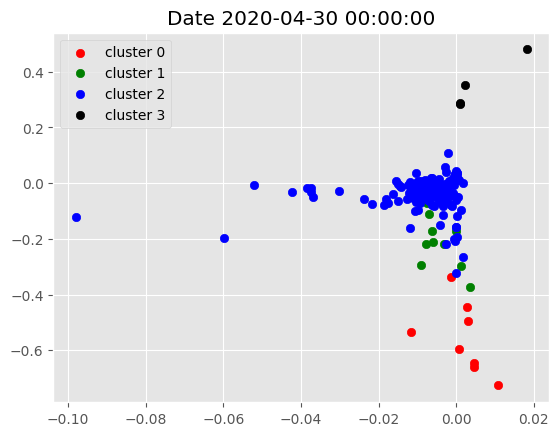

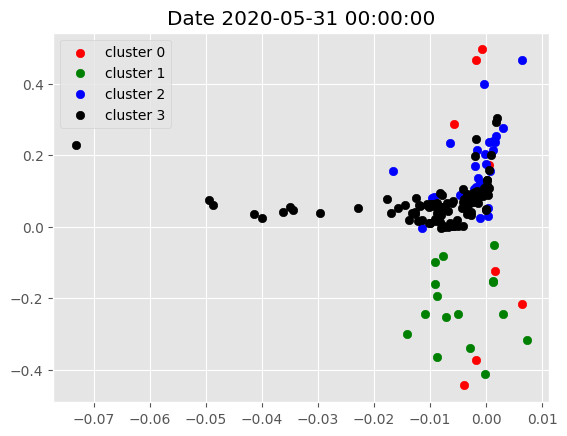

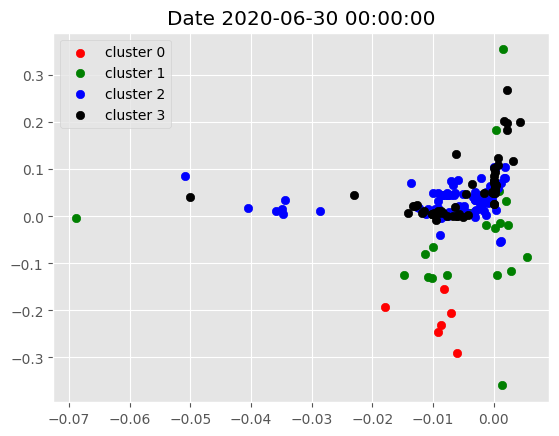

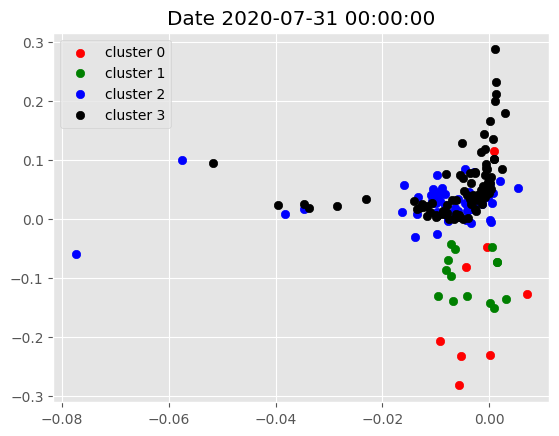

KeyboardInterrupt: 

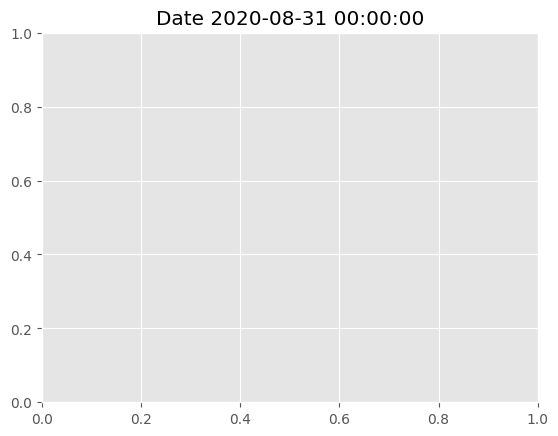

In [193]:

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

## Pick Cluster for Optimization

In [204]:

filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

In [205]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1], auto_adjust=False)

#new_df

[*********************100%***********************]  152 of 152 completed


In [206]:
import numpy as np
import pandas as pd
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.exceptions import OptimizationError
import warnings
warnings.filterwarnings('ignore')

returns_dataframe = np.log(new_df['Adj Close']).diff()

def robust_optimize_weights(prices, lower_bound=0.0, risk_free_rate=0.04, verbose=False):
    """
    Robust portfolio optimization with multiple fallback strategies

    Parameters:
    - prices: DataFrame of asset prices
    - lower_bound: minimum weight per asset
    - risk_free_rate: risk-free rate for Sharpe ratio
    - verbose: print debug information

    Returns:
    - dict: asset weights
    - str: method used for optimization
    """

    if len(prices) < 5:  # Need minimum data
        if verbose:
            print("⚠️ Insufficient data points, using equal weights")
        return {ticker: 1 / prices.shape[1] for ticker in prices.columns}, "equal_weights_insufficient_data"

    try:
        # Calculate returns and covariance
        returns = expected_returns.mean_historical_return(prices, frequency=252)
        cov = risk_models.sample_cov(prices, frequency=252)

        num_assets = prices.shape[1]

        if verbose:
            print(f"Expected returns range: {returns.min():.4f} to {returns.max():.4f}")
            print(f"Risk-free rate: {risk_free_rate:.4f}")

        # Dynamic upper bound
        max_weight = min(0.15, 1.0 / num_assets * 3)  # Allow slightly higher concentration

        # Strategy 1: Max Sharpe with original risk-free rate
        try:
            if max(returns) > risk_free_rate:
                ef = EfficientFrontier(
                    expected_returns=returns,
                    cov_matrix=cov,
                    weight_bounds=(lower_bound, max_weight),
                    solver='ECOS'  # Try ECOS first, often more reliable
                )
                ef.max_sharpe(risk_free_rate=risk_free_rate)
                weights = ef.clean_weights()
                if verbose:
                    print("✅ Max Sharpe optimization successful")
                return weights, "max_sharpe"
            else:
                raise ValueError("No assets exceed risk-free rate")

        except (OptimizationError, ValueError) as e:
            if verbose:
                print(f"Max Sharpe failed: {e}")

            # Strategy 2: Lower risk-free rate
            try:
                lower_rf = min(risk_free_rate * 0.5, max(returns) * 0.8)
                if max(returns) > lower_rf:
                    ef = EfficientFrontier(
                        expected_returns=returns,
                        cov_matrix=cov,
                        weight_bounds=(lower_bound, max_weight),
                        solver='ECOS'
                    )
                    ef.max_sharpe(risk_free_rate=lower_rf)
                    weights = ef.clean_weights()
                    if verbose:
                        print(f"✅ Max Sharpe with reduced risk-free rate ({lower_rf:.4f}) successful")
                    return weights, "max_sharpe_reduced_rf"
                else:
                    raise ValueError("Still no assets exceed reduced risk-free rate")

            except (OptimizationError, ValueError):
                if verbose:
                    print("Reduced risk-free rate also failed")

                # Strategy 3: Minimum Volatility
                try:
                    ef = EfficientFrontier(
                        expected_returns=returns,
                        cov_matrix=cov,
                        weight_bounds=(lower_bound, max_weight),
                        solver='ECOS'
                    )
                    ef.min_volatility()
                    weights = ef.clean_weights()
                    if verbose:
                        print("✅ Minimum volatility optimization successful")
                    return weights, "min_volatility"

                except OptimizationError:
                    if verbose:
                        print("Minimum volatility failed")

                    # Strategy 4: Relaxed bounds
                    try:
                        relaxed_lower = max(0.0, lower_bound * 0.5)
                        relaxed_upper = min(1.0, max_weight * 1.5)

                        ef = EfficientFrontier(
                            expected_returns=returns,
                            cov_matrix=cov,
                            weight_bounds=(relaxed_lower, relaxed_upper),
                            solver='SCS'  # Try different solver
                        )
                        ef.min_volatility()
                        weights = ef.clean_weights()
                        if verbose:
                            print("✅ Relaxed bounds minimum volatility successful")
                        return weights, "min_volatility_relaxed"

                    except OptimizationError:
                        if verbose:
                            print("Relaxed bounds also failed")

                        # Strategy 5: Risk parity (inverse volatility weighting)
                        try:
                            individual_vols = np.sqrt(np.diag(cov))
                            inv_vol_weights = 1 / individual_vols
                            inv_vol_weights = inv_vol_weights / inv_vol_weights.sum()

                            # Apply bounds
                            inv_vol_weights = np.maximum(inv_vol_weights, lower_bound)
                            inv_vol_weights = np.minimum(inv_vol_weights, max_weight)
                            inv_vol_weights = inv_vol_weights / inv_vol_weights.sum()  # Renormalize

                            weights = dict(zip(prices.columns, inv_vol_weights))
                            if verbose:
                                print("✅ Risk parity (inverse volatility) successful")
                            return weights, "risk_parity"

                        except Exception:
                            if verbose:
                                print("Risk parity failed")

                            # Strategy 6: Return-weighted (avoid negative returns)
                            try:
                                # Shift returns to be positive
                                adjusted_returns = returns - returns.min() + 0.01
                                return_weights = adjusted_returns / adjusted_returns.sum()

                                # Apply bounds
                                return_weights = np.maximum(return_weights, lower_bound)
                                return_weights = np.minimum(return_weights, max_weight)
                                return_weights = return_weights / return_weights.sum()

                                weights = dict(zip(prices.columns, return_weights))
                                if verbose:
                                    print("✅ Adjusted return weighting successful")
                                return weights, "return_weighted"

                            except Exception:
                                if verbose:
                                    print("Return weighting failed, using equal weights")

                                # Final fallback: Equal weights
                                equal_weights = {ticker: 1 / prices.shape[1] for ticker in prices.columns}
                                return equal_weights, "equal_weights_final_fallback"

    except Exception as e:
        if verbose:
            print(f"Unexpected error: {e}")
        # Ultimate fallback
        equal_weights = {ticker: 1 / prices.shape[1] for ticker in prices.columns}
        return equal_weights, "equal_weights_error"

def analyze_portfolio_weights(weights_dict, method_used, returns_data=None):
    """
    Analyze and display portfolio weight characteristics
    """
    weights_series = pd.Series(weights_dict)

    print(f"\n📊 Portfolio Analysis (Method: {method_used})")
    print(f"Number of assets: {len(weights_series)}")
    print(f"Weight range: {weights_series.min():.4f} to {weights_series.max():.4f}")
    print(f"Weight concentration (max/min): {weights_series.max()/weights_series.min():.2f}")
    print(f"Effective number of stocks: {1/np.sum(weights_series**2):.2f}")

    # Show top 5 weights
    print(f"\nTop 5 weights:")
    print(weights_series.nlargest(5).round(4))

    if returns_data is not None:
        expected_returns = expected_returns.mean_historical_return(returns_data, frequency=252)
        portfolio_return = np.sum(weights_series * expected_returns)
        print(f"\nExpected portfolio return: {portfolio_return:.4f}")

# Updated main optimization function
def optimize_weights_robust(prices, lower_bound=0.0, verbose=False):
    """
    Main function that calls the robust optimizer
    """
    weights, method = robust_optimize_weights(
        prices=prices,
        lower_bound=lower_bound,
        verbose=verbose
    )

    if verbose:
        analyze_portfolio_weights(weights, method, prices)

    return weights

# Your updated portfolio loop
def run_portfolio_optimization(new_df, returns_dataframe, fixed_dates, lower_bound=0.012, verbose=False):
    """
    Run the complete portfolio optimization loop with robust error handling
    """
    portfolio_df = pd.DataFrame()
    optimization_results = []  # Track which method was used for each period

    for i, start_date in enumerate(fixed_dates.keys()):
        if verbose:
            print(f"\n{'='*50}")
            print(f"Processing period {i+1}/{len(fixed_dates)}: {start_date}")

        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        adj_close_df = new_df.xs('Adj Close', axis=1, level=0)
        optimization_df = adj_close_df.loc[optimization_start_date:optimization_end_date, cols]

        # Check data quality
        if len(optimization_df) < 20:  # Need minimum trading days
            print(f"⚠️ Insufficient data for {start_date}, skipping...")
            continue

        # Remove any columns with insufficient data
        valid_cols = optimization_df.dropna(axis=1, thresh=len(optimization_df)*0.8).columns
        if len(valid_cols) < len(cols):
            print(f"⚠️ Removed {len(cols) - len(valid_cols)} assets due to missing data")
            optimization_df = optimization_df[valid_cols]
            cols = valid_cols.tolist()

        if len(cols) == 0:
            print(f"⚠️ No valid assets for {start_date}, skipping...")
            continue

        # Get robust weights
        weights_dict, method_used = robust_optimize_weights(
            prices=optimization_df,
            lower_bound=lower_bound,
            verbose=verbose
        )

        optimization_results.append({
            'date': start_date,
            'method': method_used,
            'n_assets': len(cols),
            'data_length': len(optimization_df)
        })

        # Convert weights dict to DataFrame
        weights = pd.Series(weights_dict).to_frame('weight')

        # Slice returns for this period
        temp_returns = returns_dataframe.loc[start_date:end_date, cols]

        # Reshape and merge returns and weights
        temp_df = temp_returns.stack().to_frame('return')
        temp_df.index.names = ['Date', 'Ticker']

        # Join weights
        temp_df = temp_df.join(weights, on='Ticker')
        temp_df['weight'] = temp_df['weight'].fillna(0)  # Handle missing weights

        # Compute weighted returns
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        # Sum by day to get portfolio return
        daily_returns = temp_df.groupby(level='Date')['weighted_return'].sum().to_frame('Strategy Return')

        # Append to full portfolio
        portfolio_df = pd.concat([portfolio_df, daily_returns], axis=0)

    # Remove duplicate index entries
    portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]

    # Print optimization summary
    if verbose:
        print(f"\n{'='*50}")
        print("OPTIMIZATION SUMMARY")
        print(f"{'='*50}")
        methods_used = pd.DataFrame(optimization_results)['method'].value_counts()
        print("Methods used:")
        for method, count in methods_used.items():
            print(f"  {method}: {count} periods")

    return portfolio_df, optimization_results

 #Usage example:
portfolio_df, results = run_portfolio_optimization(
     new_df,
     returns_dataframe,
     fixed_dates,
     lower_bound=0.012,
     verbose=True  # Set to False to reduce output
 )


Processing period 1/73: 2019-10-01
Expected returns range: 0.0220 to 0.2758
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 2/73: 2019-11-01
Expected returns range: -0.2132 to 0.3148
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 3/73: 2019-12-01
Expected returns range: -0.0263 to 0.9487
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 4/73: 2020-01-01
Expected returns range: 0.4882 to 2.2477
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 5/73: 2020-02-01
Expected returns range: -0.2809 to 0.3055
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 6/73: 2020-03-01
Expected returns range: -0.4707 to 0.3376
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 7/73: 2020-04-01
Expected returns range: 0.0192 to 0.3530
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 8/73: 2020-05-01
E

In [207]:
spy = yf.download(tickers='SPY',
                  start='2017-01-01',
                  end=dt.date.today(), auto_adjust=False)

# Flatten the multi-level index of spy_ret to a single level ('Date')
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1).droplevel(level=1, axis=1)


portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
Date,,
2019-10-01,-0.001330,-0.011966
2019-10-02,-0.003383,-0.017822
2019-10-03,0.001340,0.008159
2019-10-04,0.003966,0.013442
2019-10-07,-0.001358,-0.004324
...,...,...
2025-09-11,0.009021,0.008276
2025-09-12,-0.002665,-0.000335
2025-09-15,0.003687,0.005310


In [208]:
portfolio_df[portfolio_df['Strategy Return'] > portfolio_df['SPY Buy&Hold']].shape

(702, 2)

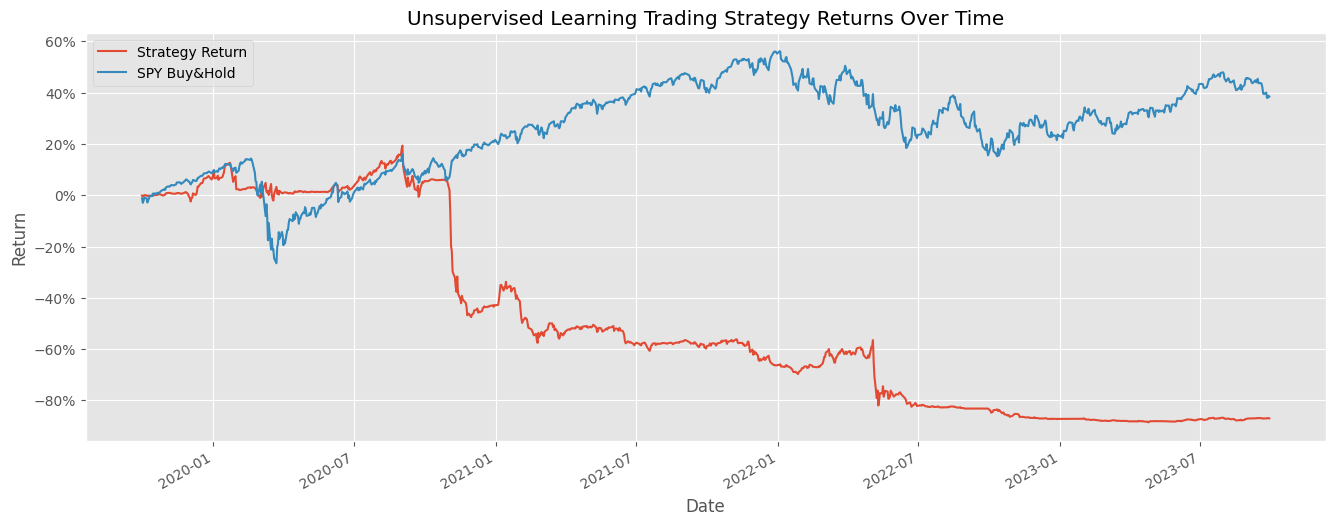

In [209]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [186]:
gross_rets = (1+portfolio_df['Strategy Return']).cumprod()
bench_rets = (1+portfolio_df['SPY Buy&Hold']).cumprod()

rets = (gross_rets * 1000)
roi = ((rets[-1] - 1000)/1000) * 100
roi

b_rets = (bench_rets * 1000)
b_roi = ((b_rets[-1] - 1000)/1000) * 100
b_roi, roi, rets[-1]

(np.float64(112.83644298691719),
 np.float64(-59.60891843015814),
 np.float64(403.91081569841856))

In [163]:
portfolio_df['Strategy Return'].mean(), portfolio_df['SPY Buy&Hold'].mean()

(np.float64(0.0008977393139795401), np.float64(0.0005901045974132171))

Strategy ROI: -59.61%
Benchmark ROI: 112.84%


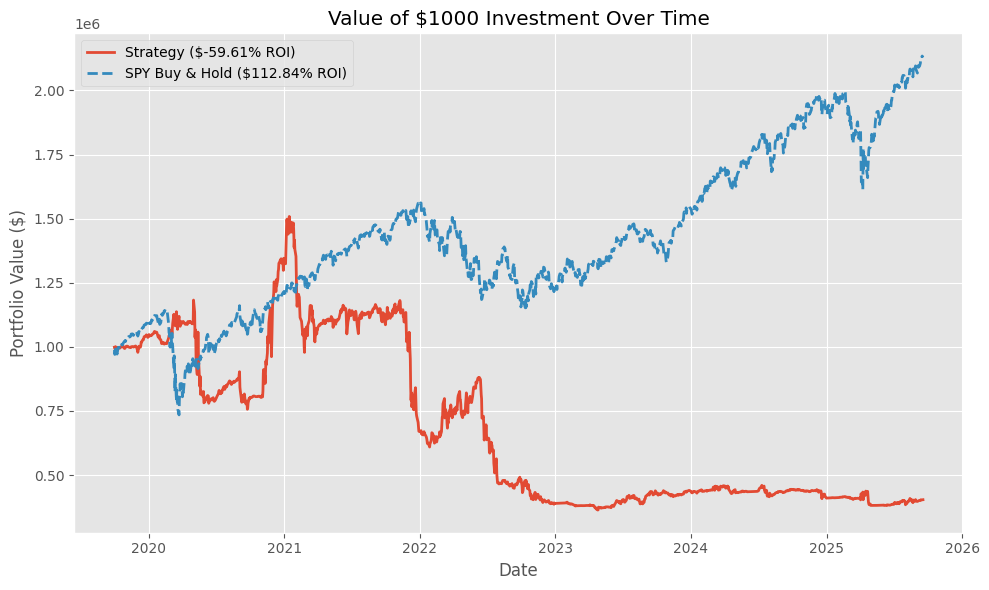

In [187]:
import matplotlib.pyplot as plt

# Calculate cumulative returns
gross_rets = (1 + portfolio_df['Strategy Return']).cumprod()
bench_rets = (1 + portfolio_df['SPY Buy&Hold']).cumprod()

# Calculate investment values starting with $1000
initial_investment = 1000000
rets = gross_rets * initial_investment
b_rets = bench_rets * initial_investment

# Calculate ROI
roi = ((rets.iloc[-1] - initial_investment) / initial_investment) * 100
b_roi = ((b_rets.iloc[-1] - initial_investment) / initial_investment) * 100

# Print ROI
print(f"Strategy ROI: {roi:.2f}%")
print(f"Benchmark ROI: {b_roi:.2f}%")

# Plot both investment values
plt.figure(figsize=(10, 6))
plt.plot(rets, label=f'Strategy (${roi:.2f}% ROI)', linewidth=2)
plt.plot(b_rets, label=f'SPY Buy & Hold (${b_roi:.2f}% ROI)', linestyle='--', linewidth=2)

plt.title('Value of $1000 Investment Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
